In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Libraries

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# For Encoding
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

# Boosting
from pyspark.ml.regression import GBTRegressor

# Evaluation
from pyspark.ml.evaluation import RegressionEvaluator 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Initializing Spark

In [ ]:
spark_context = SparkContext(appName="BIA678_D3")
spark_context

ValueError: ignored

In [ ]:
spark_session = SparkSession(spark_context)
spark_session

In [ ]:
sql_context = SQLContext(spark_session.sparkContext)
sql_context

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Loading Datasets

In [ ]:
data_details = spark_session.read.csv("train_dataset.csv", header=True)
data_details.show(5)
data_details.printSchema()

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [ ]:
data_salaries = spark_session.read.csv("train_salaries.csv", header=True)
data_salaries.show(5)
data_salaries.printSchema()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [ ]:
# As seen in the schema above, the columne: 'salary' from data_salaries, 
# 'yearsExperience' and 'milesFromMetropolis' from data_details are string.
# These columns must be casted to numeric datatype

data_salaries = data_salaries.withColumn("salary", data_salaries.salary.cast('int'))
data_salaries.printSchema()

data_details = data_details.withColumn("yearsExperience",data_details.yearsExperience.cast('int'))
data_details = data_details.withColumn("milesFromMetropolis",data_details.milesFromMetropolis.cast('int'))
data_details.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



### Merging the two pyspark dataframes

In [ ]:
print("Data Details Dataframe columns: ", data_details.columns)
print("Data Salaries Dataframe columns: ", data_salaries.columns)

Data Details Dataframe columns:  ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
Data Salaries Dataframe columns:  ['jobId', 'salary']


In [ ]:
data = data_details.join(data_salaries, ['jobId'])

In [ ]:
data.show(5)

+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+

### Managing missing values

In [ ]:
# As noticed, there are some 'NONE' values in the degree and major columns.
for column in data.columns:
  print(f"{column} column's total 'NONE' values: ", data.filter(data[column]=='NONE').count())

jobId column's total 'NONE' values:  0
companyId column's total 'NONE' values:  0
jobType column's total 'NONE' values:  0
degree column's total 'NONE' values:  236854
major column's total 'NONE' values:  532355
industry column's total 'NONE' values:  0
yearsExperience column's total 'NONE' values:  0
milesFromMetropolis column's total 'NONE' values:  0
salary column's total 'NONE' values:  0


### Managing Duplicate values

In [ ]:
# No duplicate values
duplicates=data.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
duplicates.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



### Dataset Insights

In [ ]:
# Creating SparkSQL view to perform SQL queries.
data.createOrReplaceTempView("data")

#### 1. Highest Paid Job

In [ ]:
data1 = spark_session.sql('''
    SELECT salary, jobtype
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''')
data1.show()

+------+-------+
|salary|jobtype|
+------+-------+
|   301|    CFO|
|   301|    CTO|
+------+-------+



The highset paid job is for the position of CFO and CTO, having salary of $301,000 per year.

#### 2. Top 10 Highest Paying Jobs

In [ ]:
data2 = spark_session.sql('''
          SELECT salary, jobtype, industry
          FROM data
          ORDER BY salary DESC
          LIMIT 10''')

print("Top 10 Highest paying job:\n")
data2.show()

Top 10 Highest paying job:

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
|   298|    CEO|     OIL|
|   294|    CEO| FINANCE|
|   294|    CEO|     OIL|
|   293|    CEO| FINANCE|
|   293|    CEO|     OIL|
|   292|    CEO| FINANCE|
|   292|    CTO| FINANCE|
|   290|    CEO|     WEB|
+------+-------+--------+



#### 3. Top 10 Lowest Paying Jobs

In [ ]:
data3 = spark_session.sql('''
          SELECT salary, jobtype, industry, salary
          FROM data
          ORDER BY salary ASC
          LIMIT 10''')

print("Top 10 Least paying job:\n")
data3.show()

Top 10 Least paying job:

+------+--------------+---------+------+
|salary|       jobtype| industry|salary|
+------+--------------+---------+------+
|     0|        JUNIOR|     AUTO|     0|
|     0|        JUNIOR|      OIL|     0|
|     0|VICE_PRESIDENT|      WEB|     0|
|     0|           CTO|     AUTO|     0|
|     0|       MANAGER|  FINANCE|     0|
|    17|       JANITOR|EDUCATION|    17|
|    18|       JANITOR|EDUCATION|    18|
|    18|       JANITOR|EDUCATION|    18|
|    18|       JANITOR|EDUCATION|    18|
|    19|       JANITOR|EDUCATION|    19|
+------+--------------+---------+------+



In [ ]:
# There are values in salary column that are zero, removing those.
data = data.where("salary != 0")
data.createOrReplaceTempView("data")

In [ ]:
data3 = spark_session.sql('''
          SELECT salary, jobtype, industry, salary
          FROM data
          ORDER BY salary ASC
          LIMIT 10''')

print("Top 10 Least paying job:\n")
data3.show()

Top 10 Least paying job:

+------+-------+---------+------+
|salary|jobtype| industry|salary|
+------+-------+---------+------+
|    17|JANITOR|EDUCATION|    17|
|    18|JANITOR|EDUCATION|    18|
|    18|JANITOR|EDUCATION|    18|
|    18|JANITOR|EDUCATION|    18|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
+------+-------+---------+------+



#### 4. Ranking industries based on highest average salaries.

In [ ]:
data4 = spark_session.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
data4.show()

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



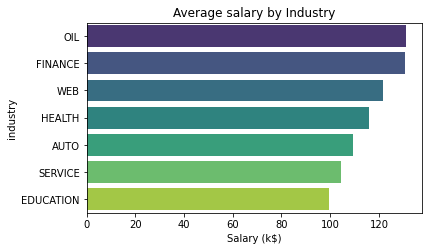

In [ ]:
data4 = data4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=data4, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

#### 5. Finding corelation between years of experience and salary.

In [ ]:
data5 = spark_session.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''')
data5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO|     OIL|             24|
|   293|    CEO| FINANCE|             16|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In [ ]:
data5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [ ]:
titles = ["CTO", "JUNIOR", "JANITOR", "CFO", "CEO", "MANAGER", "VICE_PRESIDENT", "SENIOR"]
data5 = data5.toPandas()

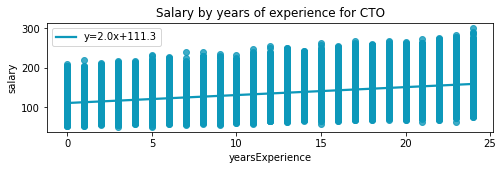

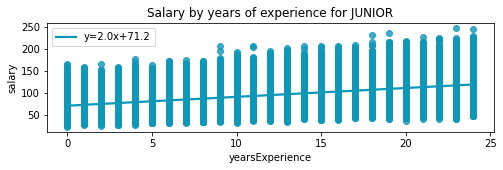

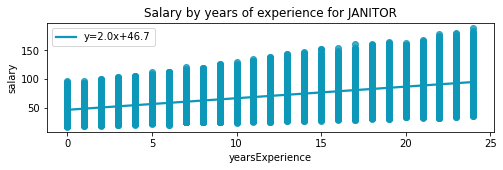

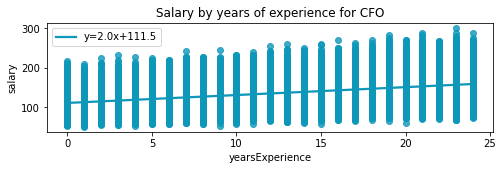

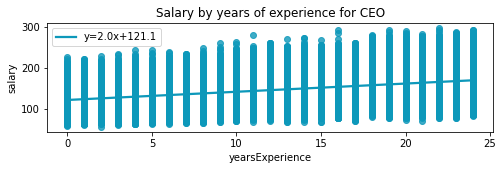

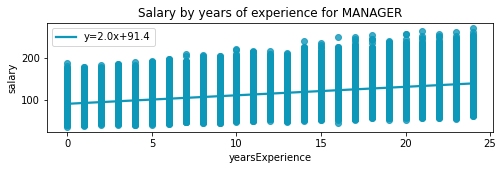

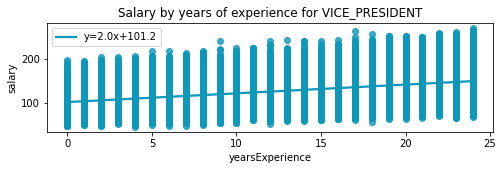

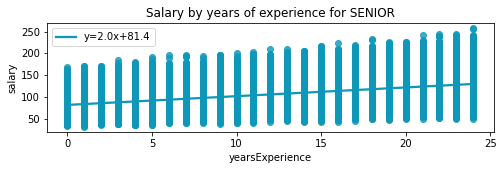

In [ ]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for title in titles:
    df_x = data5.loc[data5['jobtype']==title]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + title)
    plt.show()

#### 6. Finding corelation between degree and salary. | NEEDS GRAPH

In [ ]:
data6a = spark_session.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')

data6a.show(10)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 10 rows



In [ ]:
data6b = spark_session.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary desc
                  ''')
data6b.show(10)

+---------+------+-------+
|   degree|salary|jobtype|
+---------+------+-------+
|  MASTERS|   301|    CTO|
| DOCTORAL|   301|    CFO|
|  MASTERS|   298|    CEO|
| DOCTORAL|   294|    CEO|
|BACHELORS|   294|    CEO|
| DOCTORAL|   293|    CEO|
| DOCTORAL|   293|    CEO|
|  MASTERS|   292|    CTO|
|BACHELORS|   292|    CEO|
| DOCTORAL|   290|    CEO|
+---------+------+-------+
only showing top 10 rows



#### 7. Finding corelation between major and salary. | NEEDS GRAPH

In [ ]:
# ADD CODE HERE

### Predicting Salaries | ML

In [ ]:
data = data.drop('jobId')

In [ ]:
columns = data.columns

In [ ]:
# Encoding labels for columns representing class.
class_columns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in class_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in class_columns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [ ]:
# One Hot Encoding
class_columns = ["companyId","jobType", "major", "industry"]
for categoricalCol in class_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in class_columns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['features'] + columns
data = data.select(selectedCols)

In [ ]:
data.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [ ]:
# Splitting data into training and testing sets
train, test = data.randomSplit([0.95, 0.05])

In [ ]:
# Boosting
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [ ]:
model = gbt.fit(train)

In [ ]:
predicted_salary = model.transform(test)

In [ ]:
# Evaluation Root Mean Squared
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted_salary)
rmse

19.076659297829558

In [ ]:
# Evaluation R squared
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predicted_salary)
r2

0.7521418165574165

In [ ]:
rf_results = predicted_salary.toPandas()

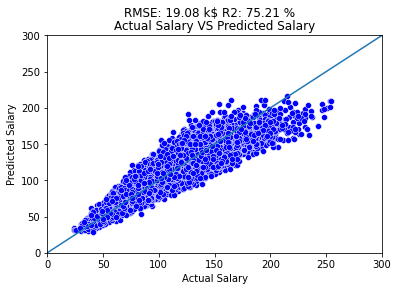

In [ ]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [ ]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

In [ ]:
spark_session.stop()